# Timing Notebook

In [1]:
# Import the usual libraries
%pylab
%matplotlib inline
import os
plt.style.use('PUBstyle')
# Import sarkas
from sarkas.processes import Simulation, PostProcess, PreProcess
from sarkas.tools.transport import TransportCoefficient

# Create the file path to the YAML input file
example_directory = os.path.join('..',
                                 os.path.join('sarkas',
                                              os.path.join('examples', 'Timing')))

input_file_names = [
    'ocp_N10k.yaml',
    'ocp_N50k.yaml',
    'ocp_N100k.yaml',
    'ocp_N500k.yaml'] 

ptcls_num = np.array([10000, 50000, 100000, 500000])
mean_pp_times = np.zeros(len(input_file_names) )
mean_pm_times = np.zeros(len(input_file_names) )
std_pp_times = np.zeros(len(input_file_names) )
std_pm_times = np.zeros(len(input_file_names) )



Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
for i, fname in enumerate(input_file_names):
    inp = os.path.join(example_directory, fname)

    preproc = PreProcess(inp)
    preproc.setup(read_yaml=True)
    preproc.run(
        timing=True, # time estimation, default is True
        loops = 10,   # the number of timesteps to average, Default is 10
        pppm_estimate=True,
        remove = True, # Save some space.
               )
    ptcls_num[i] = preproc.parameters.total_num_ptcls
    mean_pp_times[i] = np.mean(preproc.pp_acc_time[1:])
    std_pp_times[i] = np.std(preproc.pp_acc_time[1:])
    mean_pm_times[i] = np.mean(preproc.pm_acc_time[1:])
    std_pm_times[i] = np.std(preproc.pm_acc_time[1:])
    print(fname, ' Done')

In [3]:
# fig, ax = plt.subplots(1,2, figsize = (12,9), sharex = True)
# ax[0].errorbar(ptcls_num, mean_pp_times, yerr = std_pp_times, fmt = '--o')
# # ax[0].fill_between(ptcls_num, 
# #                    mean_pp_times - std_pp_times,
# #                   mean_pp_times + std_pp_times)

# ax[1].errorbar(ptcls_num, mean_pm_times, yerr = std_pm_times, fmt = '--o')
# # ax[1].fill_between(ptcls_num, 
# #                    mean_pm_times - std_pm_times,
# #                   mean_pm_times + std_pm_times)
# ax[0].set(yscale = 'log', xscale='log', ylabel = r'time per timestep [ns]', xlabel = r'$N$ = Number of particles')
# ax[1].set(yscale = 'log', xscale='log', xlabel = r'$N$ = Number of particles')

In [2]:
import pandas as pd

# data = pd.DataFrame( 
#     np.stack( (mean_pp_times, std_pp_times, mean_pm_times ,std_pm_times) , axis = 1),
#     columns = ['Python Mean PP Times', 
#                'Python Std PP Times',
#                'Python Mean PM Times',
#                'Python Std PM Times'] )

In [5]:
data = pd.read_csv('Python_timing.csv', index_col=False)

In [6]:
numbas = pd.read_csv('Numba_timing.csv', index_col=False)


In [7]:
data

,Python Mean PP Times,Python Std PP Times,Python Mean PM Times,Python Std PM Times
0,4.746795e+10,5.946179e+08,2.780403e+10,5.905404e+08
1,2.093764e+11,1.216310e+09,1.367559e+11,1.056775e+09
2,4.390014e+11,1.687709e+09,2.726222e+11,1.110827e+09
3,1.886835e+12,1.176304e+10,1.402024e+12,1.525426e+10


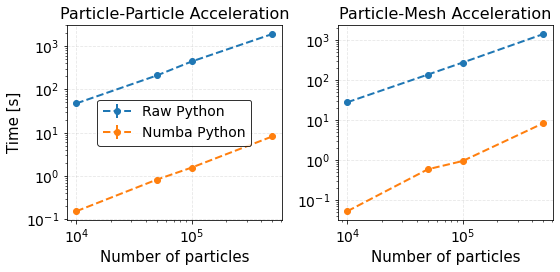

In [20]:
fig, ax = plt.subplots(1,2, figsize = (8,4), sharex = True)
ax[0].errorbar(ptcls_num, 
               data['Python Mean PP Times']*1e-9, 
               yerr = data['Python Std PP Times']*1e-9, fmt = '--o', label = 'Raw Python')
ax[0].errorbar(ptcls_num, numbas["Numba Mean PP Times"]*1e-9, 
               yerr = numbas["Numba Std PP Times"]*1e-9, fmt = '--o', label = 'Numba Python')

# ax[0].fill_between(ptcls_num, 
#                    mean_pp_times - std_pp_times,
#                   mean_pp_times + std_pp_times)

ax[1].errorbar(ptcls_num, 
               data['Python Mean PM Times']*1e-9, 
               yerr = data['Python Std PM Times']*1e-9, fmt = '--o', label = 'Raw Python')
ax[1].errorbar(ptcls_num, numbas["Numba Mean PM Times"]*1e-9, yerr = numbas["Numba Std PM Times"]*1e-9,
               fmt = '--o', label = 'Numba Python')
# ax[1].fill_between(ptcls_num, 
#                    mean_pm_times - std_pm_times,
#                   mean_pm_times + std_pm_times)
ax[0].set(title = 'Particle-Particle Acceleration', yscale = 'log', xscale='log', ylabel = r'Time [s]', xlabel = r'Number of particles')
ax[1].set(title = 'Particle-Mesh Acceleration', yscale = 'log', xscale='log', xlabel = r'Number of particles')
ax[0].legend()
# ax[1].legend()
fig.tight_layout()
fig.savefig('Timing.pdf')

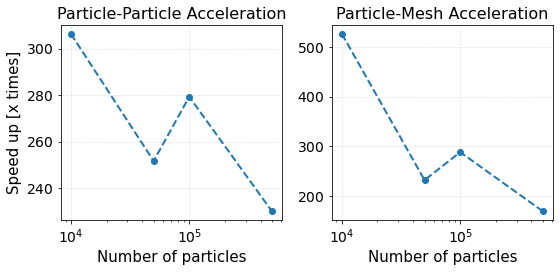

In [23]:
fig, ax = plt.subplots(1,2, figsize = (8,4), sharex = True)
ax[0].plot(ptcls_num, data["Python Mean PP Times"]/numbas["Numba Mean PP Times"], '--o')

ax[1].plot(ptcls_num, data["Python Mean PM Times"]/numbas["Numba Mean PM Times"], '--o')
ax[0].set(title = 'Particle-Particle Acceleration', xscale='log', ylabel = r'Speed up [x times]', xlabel = r'Number of particles')
ax[1].set(title = 'Particle-Mesh Acceleration',  xscale='log', xlabel = r'Number of particles')
fig.tight_layout()
fig.savefig('Speed_up.pdf')

In [10]:
data2 = pd.DataFrame()
data2["Particles"] = ptcls_num
data2 = pd.concat([data2, numbas, data], axis = 1)

In [4]:
data2 = pd.read_csv('Timing_Data.csv', index_col = False, encoding = 'utf-8')

0    0.689771
1    1.232706
2    1.019022
3    1.105483
dtype: float64

In [10]:
data2["Numba Std PM Times"]/data2["Numba Mean PM Times"]*100

0    0.686149
1    2.062843
2    2.558796
3    0.442538
dtype: float64

In [11]:
data2["Python Std PP Times"]/data2["Python Mean PP Times"]*100

0    1.252673
1    0.580920
2    0.384443
3    0.623427
dtype: float64

In [12]:
data2["Python Std PM Times"]/data2["Python Mean PM Times"]*100

0    2.123939
1    0.772745
2    0.407460
3    1.088017
dtype: float64

In [2]:
ptcls_num/(3.299463e-08**3)

array([2.78400629e+26, 1.39200315e+27, 2.78400629e+27, 1.39200315e+28])